# Solving the Cracker Barrel Peg Game with an Algorithm
> Objective: Simulate and Solve the Cracker Barrel Peg Game
1. Create a working peg game
    - 1a. Create a Graph that represents the nodes of the peg game
    - 1b. Create a method to determine if the node contains a peg
    - 1c. Create a function that evaluates if a move is legal (ie a viable jump)
    - 1d. Create a function that evaluates if any legal moves are available (successor function)
    - 1e. Create a scoring function
    - 1f. Create a random actor so that we can calculate probability of winning at random
2. Use Naive Search (BFS or DFS) to Solve the Peg Game & Return the Winning Sequence Of Moves
3. Visualize the Winning Sequence

In [63]:
import numpy as np
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [64]:
# create a function to initiate the peg positions, returned as a dictionary of nodes and binary status 0 = no peg , 1= peg
def create_nodes_list(layers=5):
    # Create our Nodes/Holes - theoretically you can use the layers argument to make your peg board larger
    # 5 Layers recreates teh iconic cracker barrel peg game
    nodes = []
    for i in range(layers):
        n = i + 1
        for j in range(n):
            if len(nodes)==0:
                nodes.append(0)
            else:   
                next_node = max(nodes)
                nodes.append(next_node+1)
    return nodes

#to visualize our graph, I want to set coordinates for the pegs, to do that I want to assign layers to the graph
def create_layers_list(layers=5):
    nodes = create_nodes_list(layers = layers)
        # now we need to organzie our nodes into layers (probably other ways to create this graph, but this is how my brain wanted to solve it)
    # I refuse to use chat gpt
    single_layer = []
    temp_nodes = nodes.copy()
    layers_list = []
    for layer in range(layers):
        n = layer + 1
        single_layer = temp_nodes[:n]
        del temp_nodes[:n]
        layers_list.append(single_layer)
    #layers are rows of nodes in our triangle
    return layers_list

# simple function to return the layer indices of a given node
def return_indices(node):
    layers_list =create_layers_list()
    for l in layers_list:
        for n in l:
            if node == n:
                layer_index = layers_list.index(l)
                row_index = l.index(n)
                return layer_index, row_index
#create a function taht returns all edges
def create_all_edges_list():
    nodes = create_nodes_list()
    layers_list = create_layers_list()
    # now we loop through all combinations and evaluate if there's a viable connection/edge       
    all_edges = []
    for n in nodes:
        for n2 in nodes:
            if n != n2:
                layer_index, row_index = return_indices(n)
                layer_index2, row_index2 = return_indices(n2)
                #to be a valid edge two things must be true, layer index variance must be -1 or zero and row var must be 0 or 1
                layer_var = layer_index-layer_index2
                row_var = row_index - row_index2
                if layer_var in[-1,0] and row_var in [0,-1]:
                    edge = (n,n2)
                    #test if we have the inverse already - may need to remove this if edges need to be bi-directional
                    if (n2,n) not in all_edges:
                        all_edges.append(edge)
    #display a few of our edges
    return all_edges 

def init_peg_dict(starting_missing_peg=0):
    nodes = create_nodes_list()
    #now that I have my nodes/holes, lets create a dictionary where the key is the hole and value is 1 (has peg) 0 (no peg here)
    peg_dict = {}
    for n in nodes:
        key = n
        if n == starting_missing_peg:
            val = 0
        else:
            val = 1
        peg_dict[key] = val

    return peg_dict
#example
init_peg_dict()

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1}

In [144]:
#create a function to remove a peg from the dictionary by passing the function a node
def remove_peg(node,peg_dict):
    peg_dict[node] = 0
    return peg_dict

# okay now we want to create a dictionary of xy coordinates to specify our layout
def create_coords_dict(layers=5):
    layers_list = create_layers_list()
    #lets assume node zero is the starting point x=0,y=0 and edge len =1
    #iterate through each layer
    # y of each layer = edge len * layer index + starting y
    # x of each node = is either x of prior node + edge len OR when layer index = 0 then x= .5 * edge len * layer index
    edge_len = 1
    coords_dict ={}
    # iterate through layer list
    for l in layers_list:
        for n in l:
            key = n
            # to get y i need the layer times the edge len
            layer_index = layers_list.index(l)
            y = layer_index * edge_len * -1 *.86666 #.866 is the height of an equallateral triangle relative to the size
            # to get x, I need the edge index
            edge_index = l.index(n)
            layer_start_x = .5*edge_len * layer_index * -1
            if edge_index != 0:
                x = layer_start_x + edge_index * edge_len
            else:
                x= layer_start_x

            coords_dict[key] = (x,y)

    return coords_dict

#calc distance between two nodes
def calc_dist(start_node,end_node):
    coords_dict=create_coords_dict()
    start_x, start_y = coords_dict[start_node]
    end_x, end_y = coords_dict[end_node]
    dist = np.sqrt((start_x - end_x)**2 + (start_y-end_y)**2)
    dist = round(dist,1)
    return dist

# to find out if a move is legit, we need to get a list of edges that include a given node
def create_list_of_edges_that_contain_node(n):
    all_edges = create_all_edges_list()
    edge_list = []
    for e in all_edges:
        if n in e:
            edge_list.append(e)
    return edge_list 

# given two nodes with distance of 2 (ie adjacent)
# return the node that sits between them
# should return none if distance !=2
def find_middle_node(node_1,node_2):
    #first test if the distance = 2
    dist = calc_dist(node_1,node_2)
    if dist == 2:
        #create two lists of edges that contain our start and end nodes
        list1 = create_list_of_edges_that_contain_node(node_1)
        list2 = create_list_of_edges_that_contain_node(node_2)
        #then compare our lists to determine which node is included in both lists
        stripped_list_1 = []
        #now strip off the matching nodes
        for e in list1:
            for n in e:
                if n != node_1:
                    stripped_list_1.append(n)
        #now we do the same thing for list 2
        stripped_list_2 =[]
        for e in list2:
            for n in e:
                if n != node_2:
                    stripped_list_2.append(n)

        #now find the node that exists in both lists
        for n in stripped_list_1:
            if n in stripped_list_2:
                middle_node = n
        return middle_node

#combine the above functions to determine if a given combinations of nodes can return a legit move    
def test_legal_move(start_node,end_node,peg_dict):
    #return a binary of 1 if move is valid
    #init the binary variable that we will return
    binary = 0
    #capture all of the information we need to determine legality
    # start node peg status
    start_node_peg = peg_dict[start_node]
    # final node peg status
    end_node_peg = peg_dict[end_node]
    
    #lets test a few assumptions before calling anymore functions
    if start_node_peg == 1 and end_node_peg == 0:

        #okay if those are valid, lets find the middle node and 


    
    
        #if start_node peg binary = 1
        if start_node_peg == 1:
            #if end node peg binary ==0 (ie we have a peg to jump in our middle node)
            if end_node_peg == 0:
                # if the destination node is open
                # and the dist between start and end node is 2 
                dist = calc_dist(start_node,end_node)
                if dist == 2:
                    #if the middle node peg = 1
                    middle_node = find_middle_node(start_node,end_node)
                    middle_node_peg = peg_dict[middle_node]
                    if middle_node_peg == 1:
                        binary = 1
        return binary
                        

def create_list_of_current_legal_moves(peg_dict):
    legal_moves = []
    occupied_nodes = [key for key in peg_dict.keys() if peg_dict[key]==1]
    empty_nodes = [n for n in peg_dict.keys() if peg_dict[n]==0]
    for o in occupied_nodes:
        for e in empty_nodes:
            if test_legal_move(o,e,peg_dict)==1:
                legal_moves.append((o,e))
    return legal_moves

#now we need to create a function to process a move,
# so we pass it a legal move and the peg dict and it changes the peg dict in two ways
# first node in the move tuple is now empty
# middle node is now empty 
# second node in the tuple has a peg
# then return the updated dict
def process_move(peg_dict,move):
    #create a new peg dictionary to keep them straigh (probably not efficient)
    new_dict = peg_dict.copy()
    #now we need to make the first node in our move tuple empty
    new_dict[move[0]] = 0 
    #now we need to find the middle node and make empty
    jumped_node = find_middle_node(move[0],move[1])
    new_dict[jumped_node] = 0
    #the make the destination have a peg
    new_dict[move[1]] = 1

    #return new dict means that your game loop is going to need to set dict to this output
    return new_dict
    
#I'm curious about the probability of winnning by random so I want to simulate random moves
#create a function to select a legal move at random
def select_random_move(peg_dict):
    legal_moves = create_list_of_current_legal_moves(peg_dict)
    n_moves = len(legal_moves)
    if n_moves > 0:
        y = random.randint(0,n_moves-1)
        move = legal_moves[y]
        #leaving this in the if means the function returns nothing when there are no legal moves
        return move
    

def run_random_game():
    peg_location_list = []
    move_num = 0
    move_num_list= []
    move_list = []
    peg_dict = init_peg_dict()
    #add the starting values to our lists
    peg_location_list.append(peg_dict.copy())
    move_num_list.append(move_num)
    move_list.append(None)
    #init a variable called legal_move_ct 
    legal_move_ct = len(create_list_of_current_legal_moves(peg_dict))
    while legal_move_ct > 0:
        move_num += 1
        move = select_random_move(peg_dict)
        move_num_list.append(move_num)
        move_list.append(move)
        peg_dict = process_move(peg_dict,move)
        peg_location_list.append(peg_dict.copy())
        legal_move_ct = len(create_list_of_current_legal_moves(peg_dict))
        # print(legal_move_ct)
    return move_num_list, move_list, peg_location_list

In [66]:
def scoring_label(n_pegs):
    #return the scoring label as a string based on the number of remaining pegs
    if n_pegs == 1:
        return 'You\'re a Genius'
    elif n_pegs == 2:
        return 'Purty Smart'
    elif n_pegs == 3:
        return 'You\'re Just Plain Dumb'
    else:
        return 'Eg-no-ra-moose'

#create a function to draw a grid
def draw_board(peg_dict):
    nodes = create_nodes_list()
    all_edges = create_all_edges_list()
    # #init the graph
    G = nx.Graph()
    #add our nodes and edges
    G.add_nodes_from(nodes)
    G.add_edges_from(all_edges,lengths=10)
    # Draw the graph
    nx.draw(G,pos = create_coords_dict(), with_labels=True, node_color=['#e63946' if peg_dict[n] == 0 else '#a8dadc' for n in G.nodes()], node_size=800, font_size=12, font_weight='bold')
    # Display the graph
    n_pegs = sum(peg_dict.values())
    plt.title(f"You're a {scoring_label(n_pegs)} - {n_pegs} Pegs Remain")
    plt.show()

def draw_move(peg_dict,move):
    nodes = create_nodes_list()
    all_edges = create_all_edges_list()
    # #init the graph
    G = nx.Graph()
    #add our nodes and edges
    G.add_nodes_from(nodes)
    G.add_edges_from(all_edges,lengths=10)
    #define some colors
    start_node_color = '#457b9d'
    end_node_color = '#e07a5f'
    empty_hole_color = '#e63946' 
    full_hole_colore = '#a8dadc'
    #now init a list of colors
    col_list = []
    #now create our color list
    for hole in peg_dict.keys():
        if hole == move[0]:
            col_list.append(start_node_color)
        elif hole == move[1]:
            col_list.append(end_node_color)
        elif peg_dict[hole] == 1:
            col_list.append(full_hole_colore)
        else:
            col_list.append(empty_hole_color)

    # Draw the graph
    #need to create an array of colors where the pegs are green if they are part of the move
    #red if empty 
    #otherwise grey
    nx.draw(G,pos = create_coords_dict(), with_labels=True, node_color=col_list, node_size=800, font_size=12, font_weight='bold')
    # Display the graph
    plt.title(f"Move {move[0]} to {move[1]}")
    plt.show()

# Demonstrate a Few of Our Game Functions

1. Initiate a new game
2. Draw the Board
3. Draw a move
4. Process the Move & Redraw our Peg Board

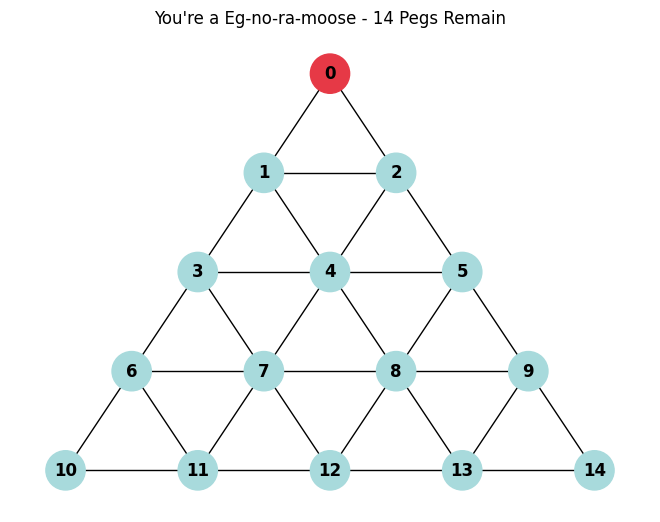

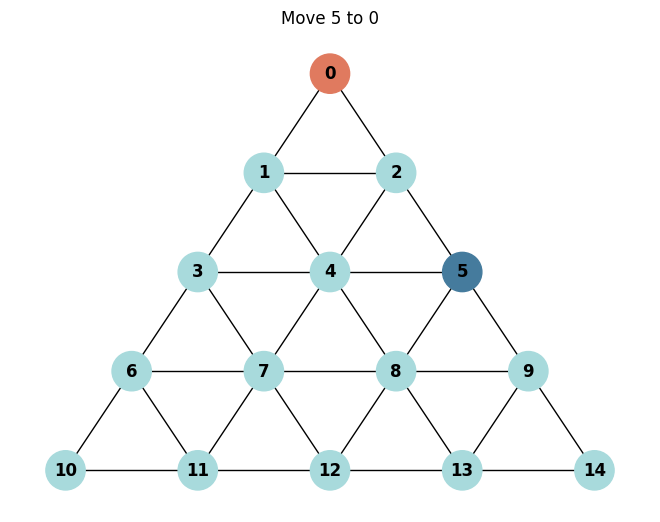

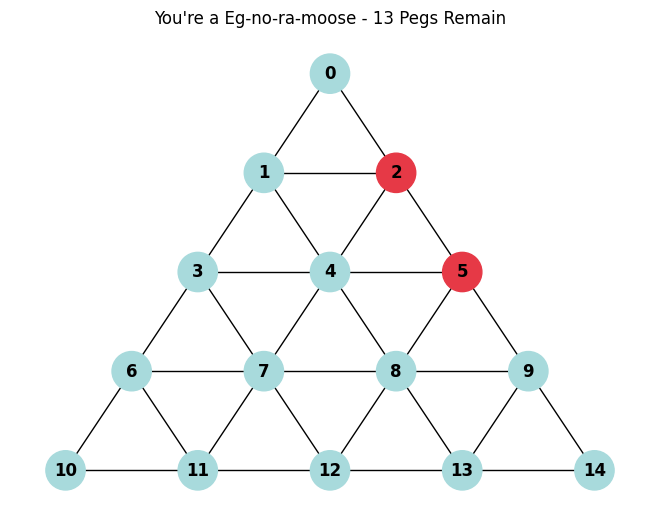

In [67]:
peg_dict = init_peg_dict()
# draw_move(peg_dict,create_list_of_current_legal_moves(peg_dict)[0])
draw_board(peg_dict)
move = (5,0)
draw_move(peg_dict,move)
process_move(peg_dict,move)
draw_board(peg_dict)


# Demonstrate a Randomized Game

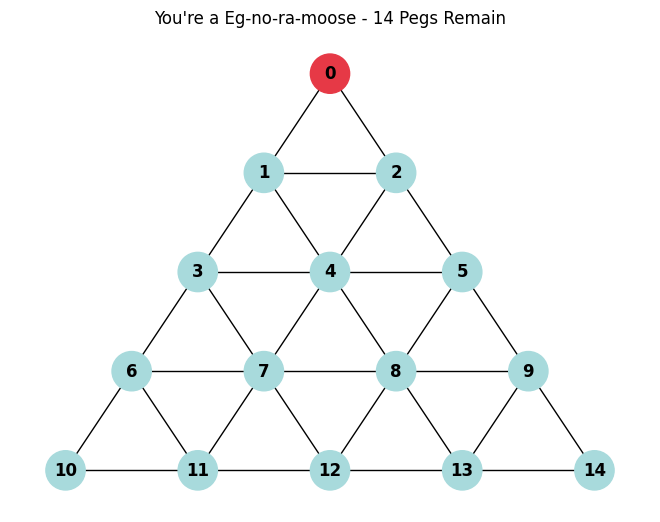

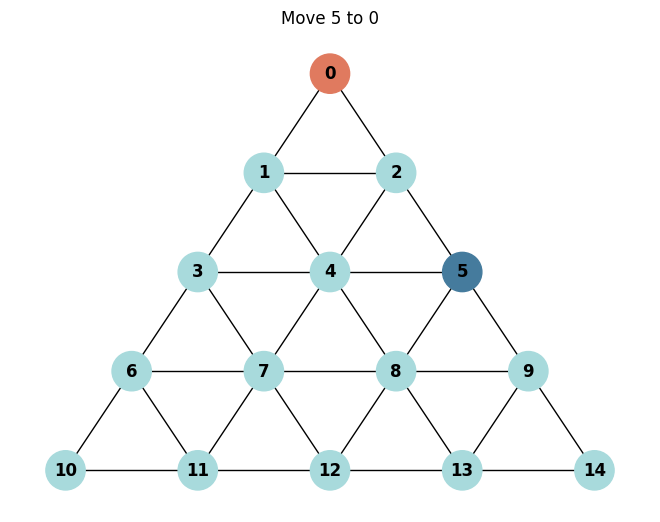

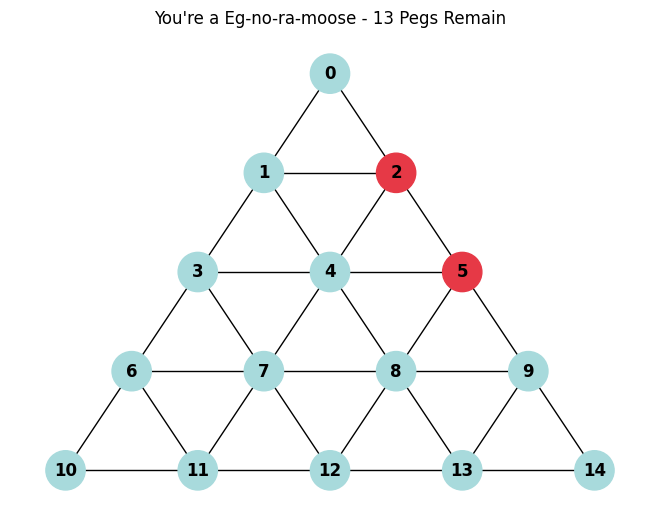

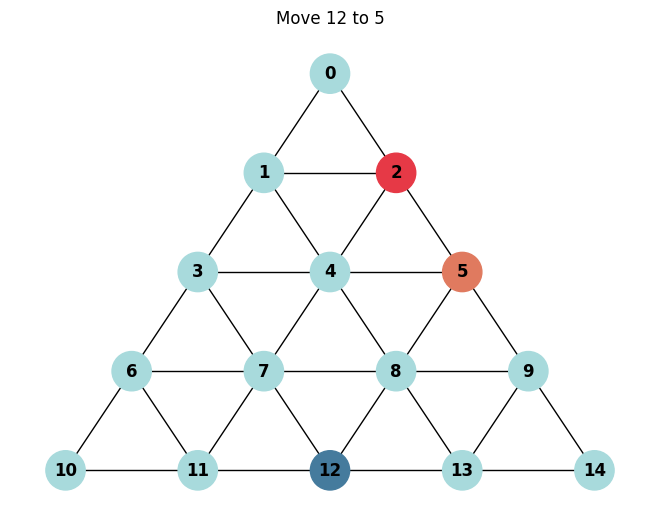

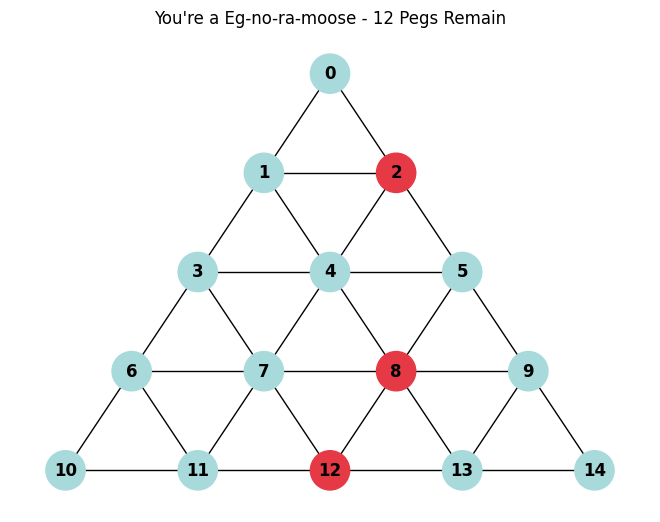

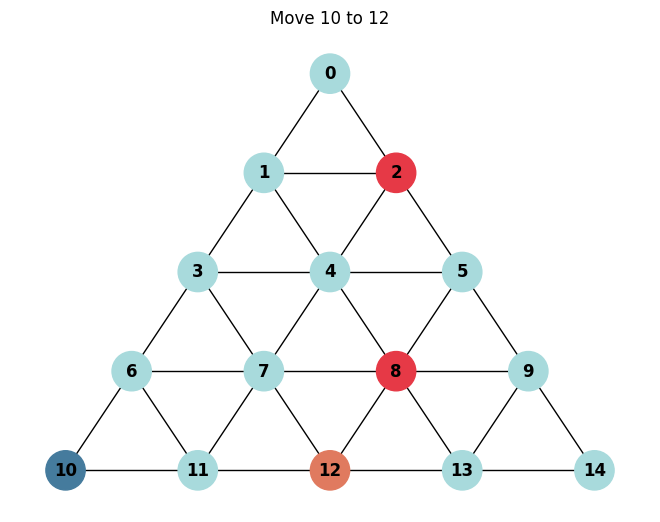

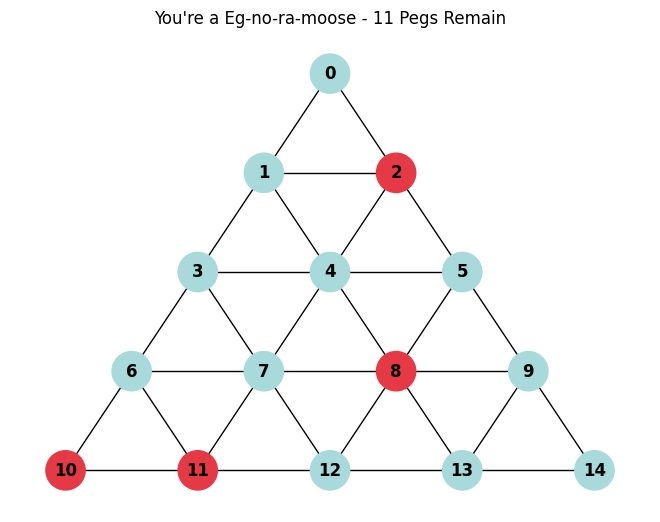

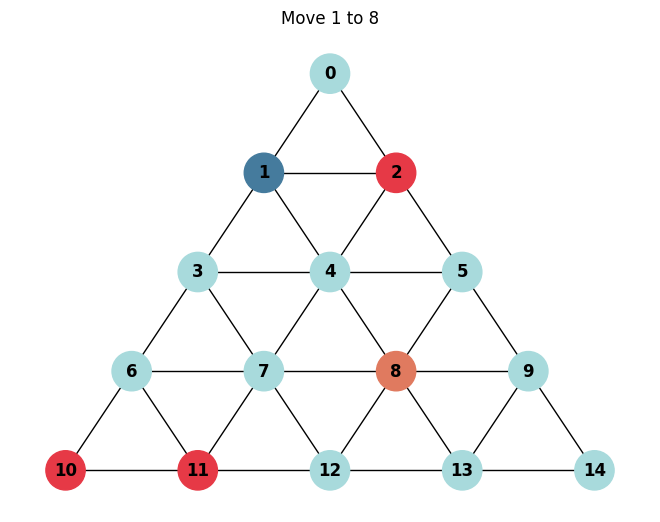

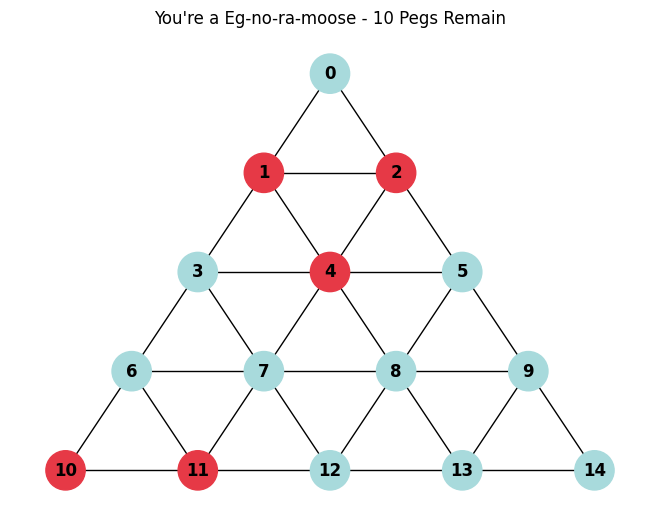

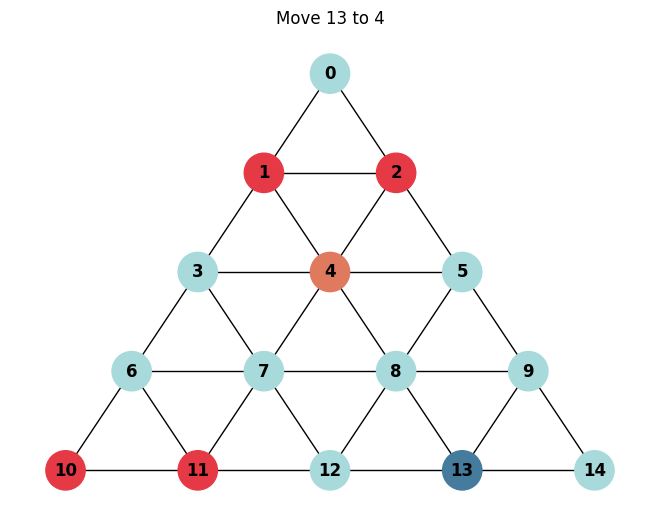

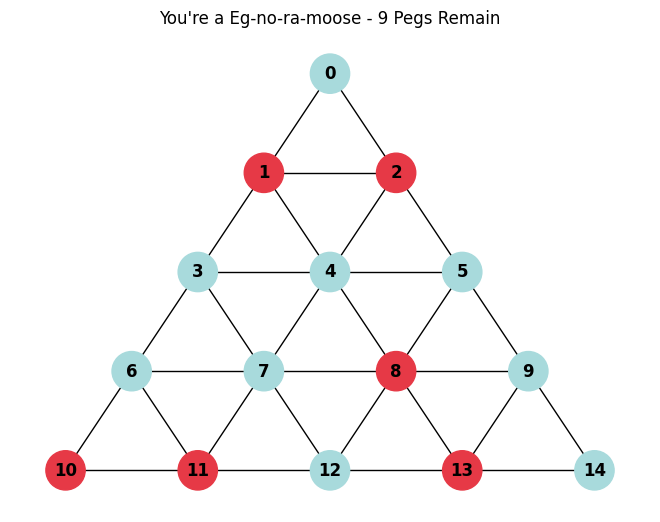

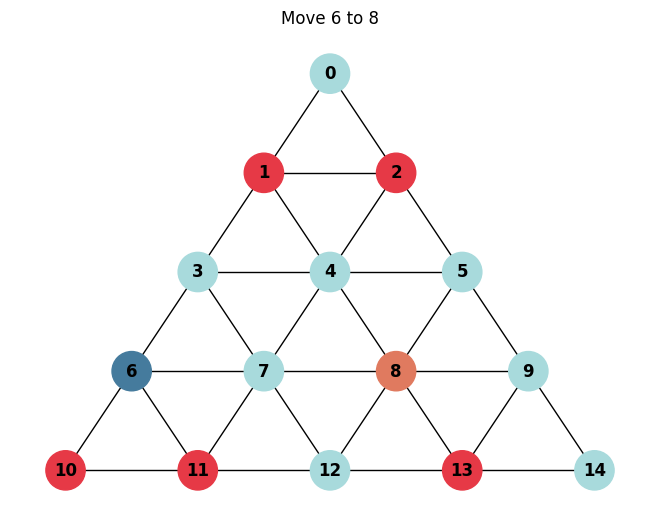

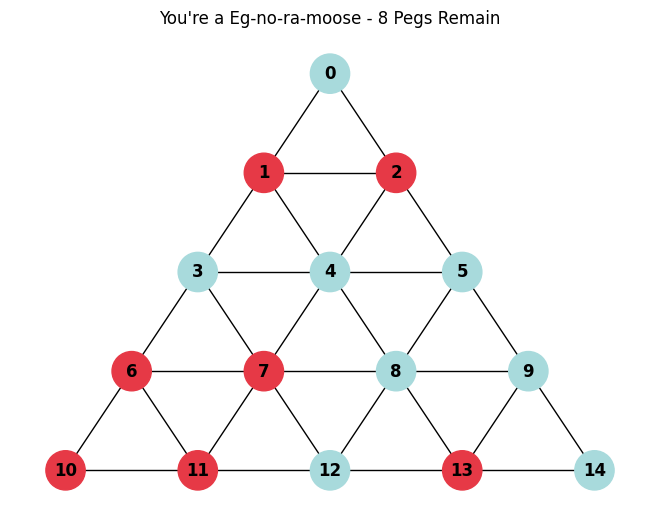

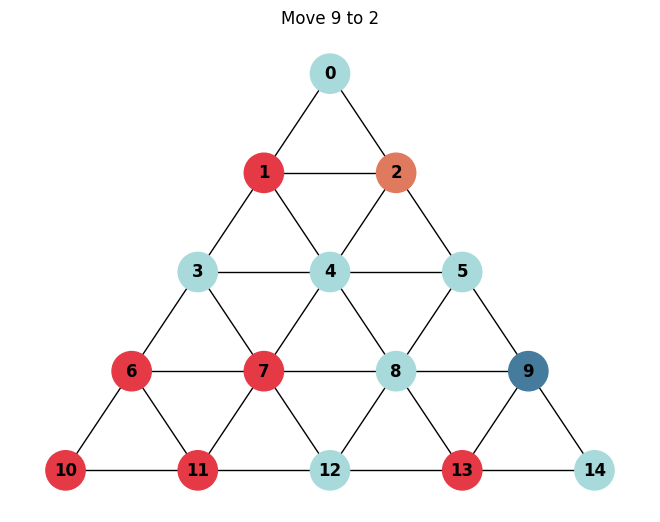

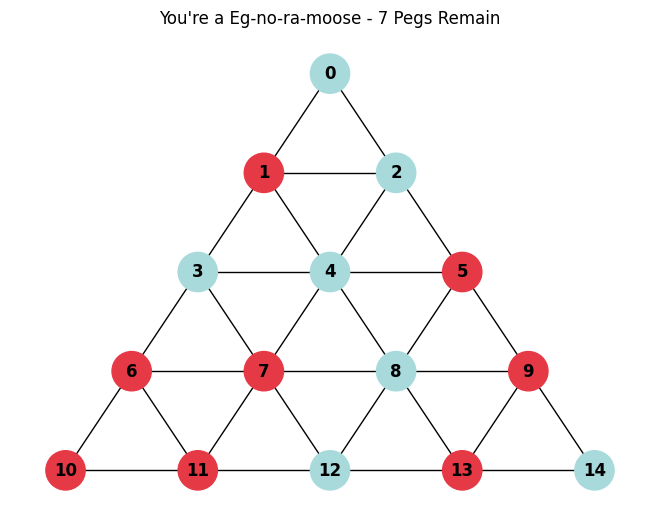

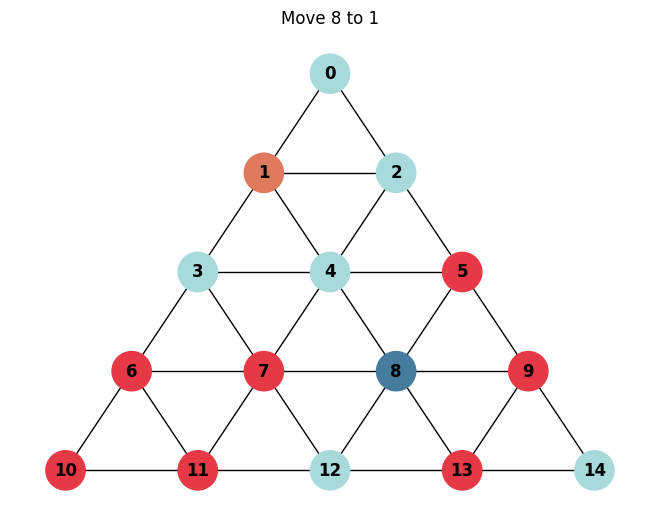

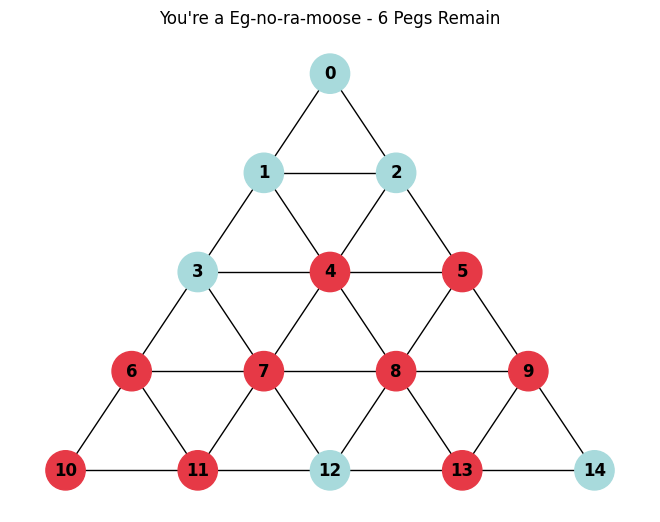

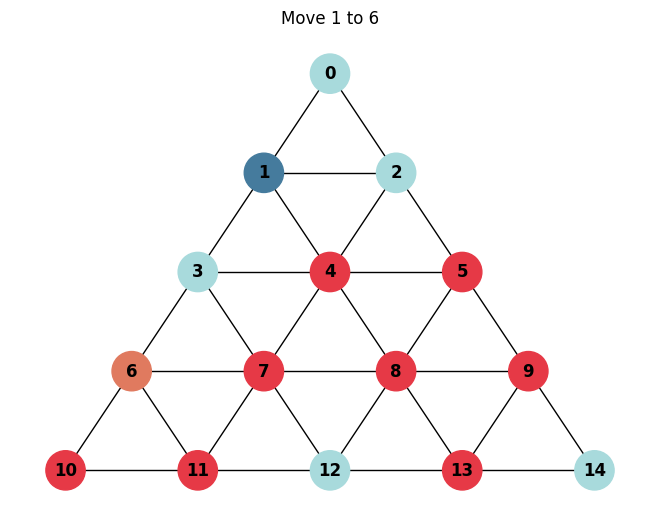

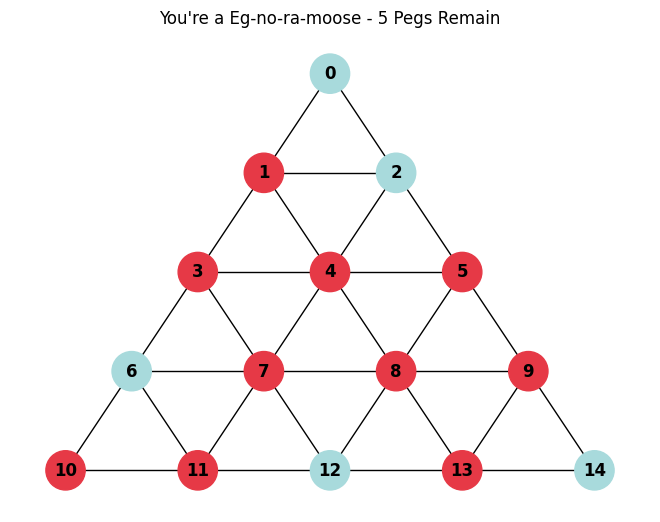

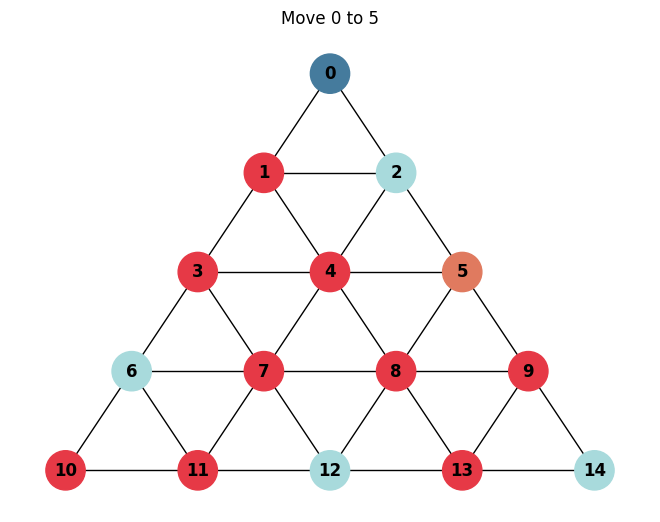

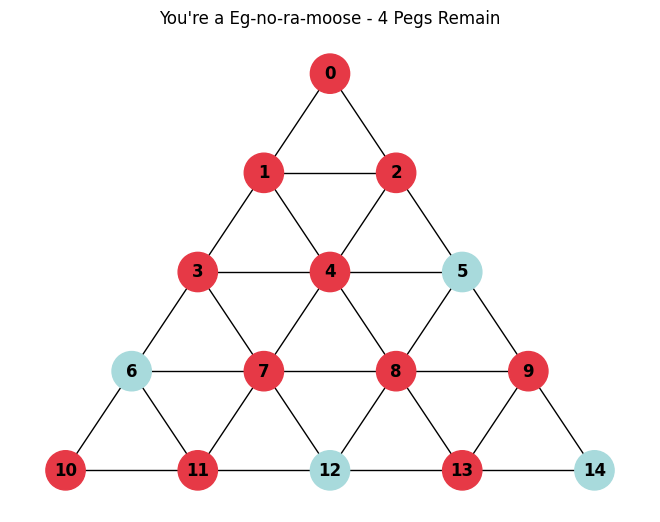

In [68]:
n_moves, move_list, states = run_random_game()
for i,state in enumerate(states):
    draw_board(state)
    try:
        draw_move(state,move_list[i+1])
    except:
        pass

# Lets Run a Mess of Random Peg Games and Show the Distribution of Results

In [75]:
n_runs = 1000
remaining_pegs_list =[]
for run in range(n_runs):
    n_moves, move_list, states = run_random_game()
    final_n_pegs = sum(states[-1].values())
    remaining_pegs_list.append(final_n_pegs)

In [76]:
# Create a Series from the array
series = pd.Series(remaining_pegs_list)
# Calculate the frequency of each value
frequency_df = series.value_counts().reset_index()
# Rename the columns
frequency_df.columns = ['val', 'freq']
frequency_df=frequency_df.assign(pct = lambda x: x.freq/len(remaining_pegs_list),
                                label = lambda x: round(x.pct*100,1).astype(str)+'%' )

fig=px.bar(frequency_df,x='val',y='pct',width=500,template='seaborn',text='label',
        title = 'Pct of Random Games Leaving n Pegs')
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=frequency_df['val'].unique(),  # Use the unique values in your 'day' column
        ticktext=frequency_df['val'].unique()  # Use the same values for labels
    )
)
fig.show()

# Finally Lets use BFS to Find the Solution

In [161]:
#create a function to determine if the game is solved
def is_winning_state(peg_dict):
    return sum(peg_dict.values())==1

#create our bfs search
def search(peg_dict):
    fringe = []
    explored = []
    fringe.append((peg_dict,[]))
    while fringe:
        #pop off a state
        current_state = fringe.pop()
        #if this is a winner then return the list of moves that got us here
        if is_winning_state(current_state[0]):
            return current_state[1]
        else:
            #if it isn't a winning state, then loop through all the valid moves from this position
            moves = create_list_of_current_legal_moves(current_state[0])
            for move in moves:
                update_state = process_move(current_state[0],move)
                #if the outcome state of a given move has not been explored yet, add it to the explored list and the fringe
                if update_state not in explored:
                    explored.append(update_state)
                    updated_move_list = current_state[1] + [move]
                    fringe.append((update_state,updated_move_list))

            



In [163]:
starting_board = init_peg_dict()
solution = search(starting_board)

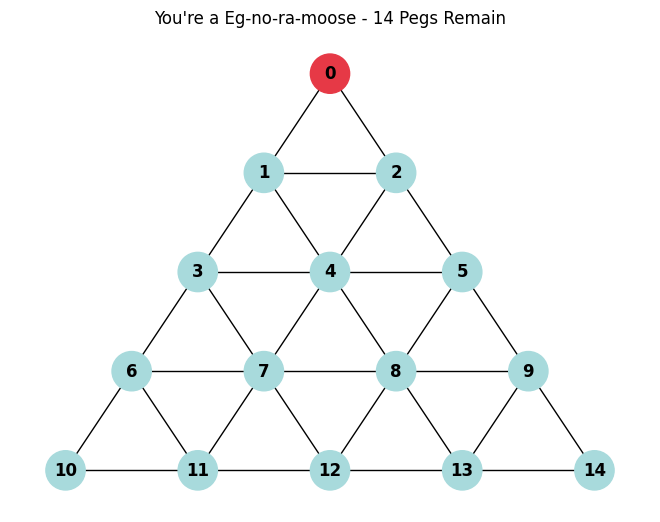

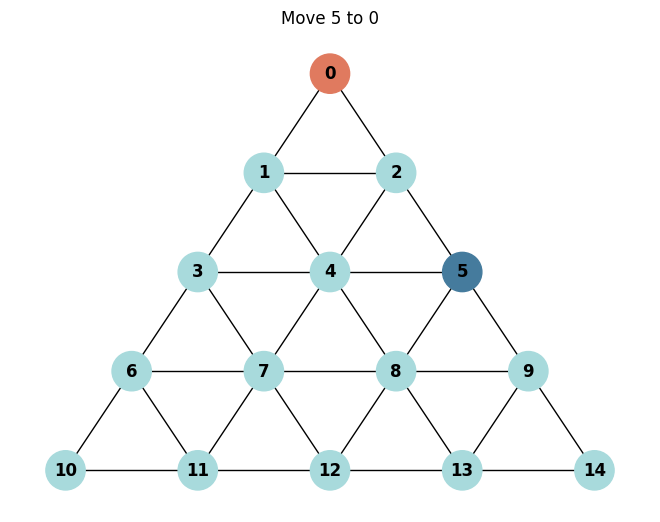

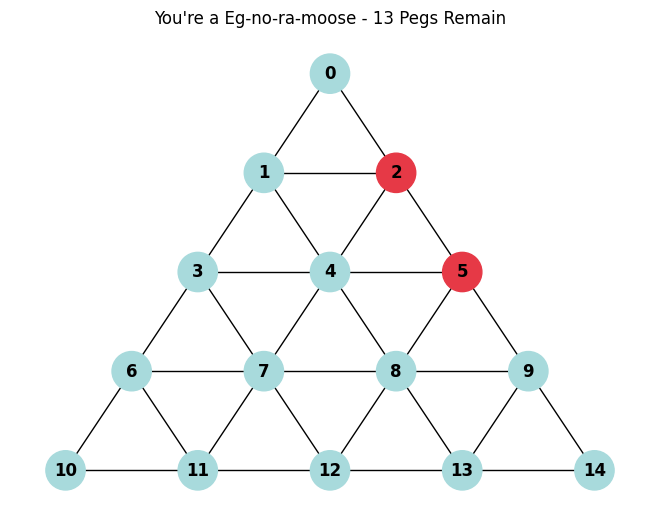

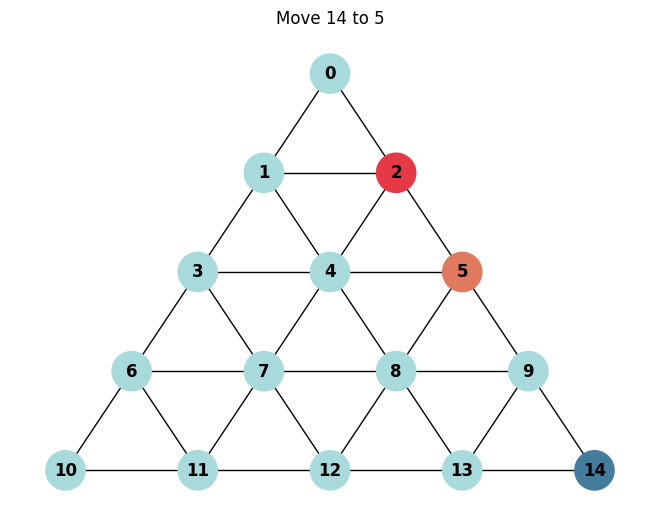

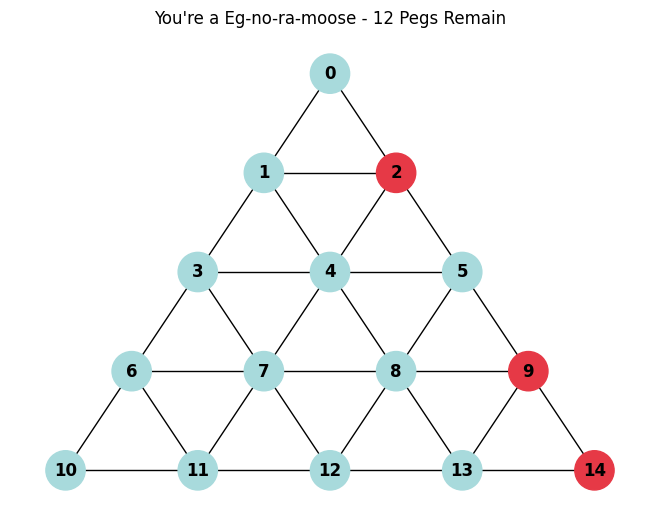

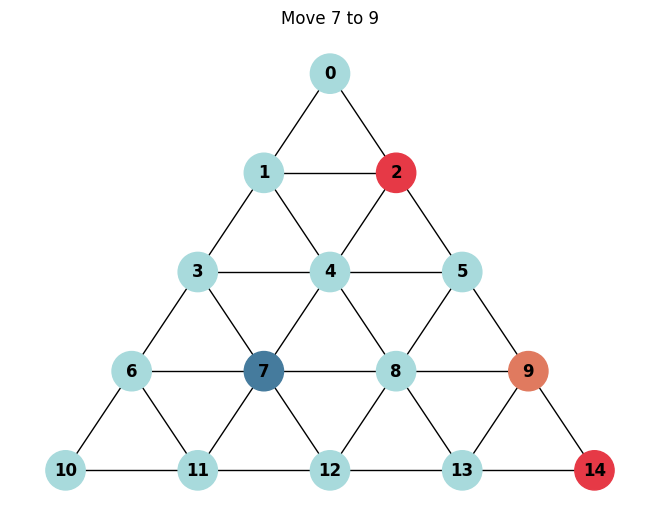

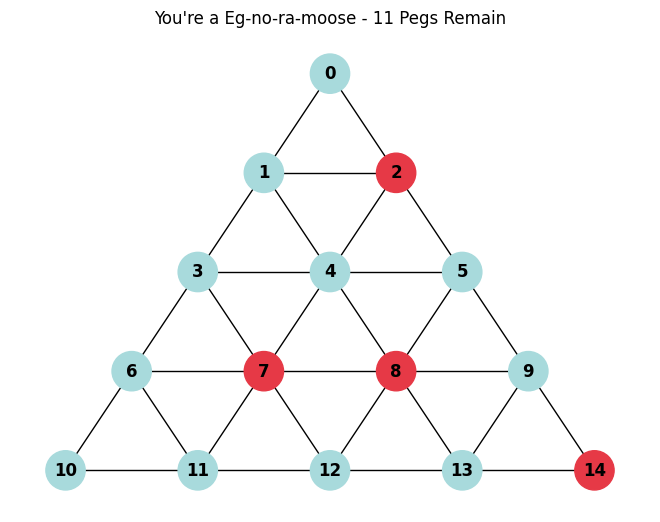

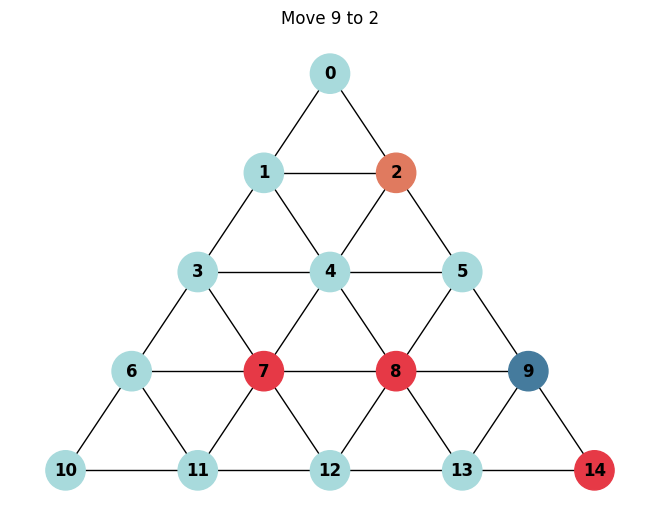

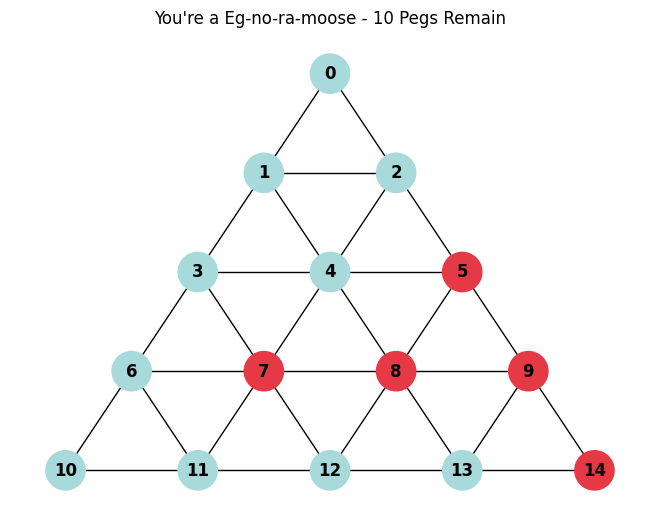

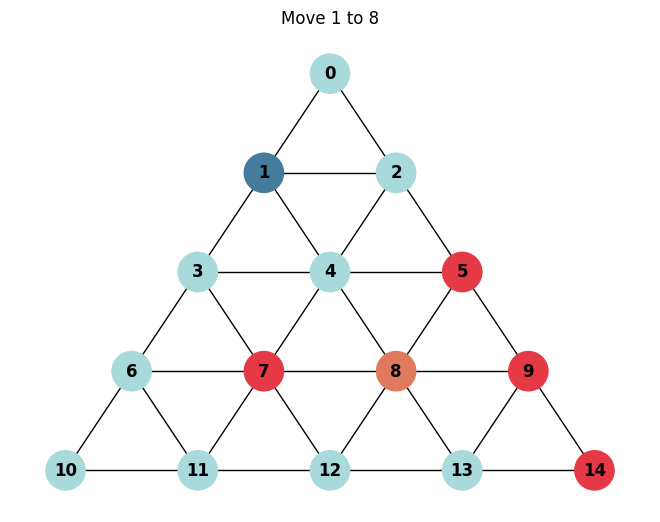

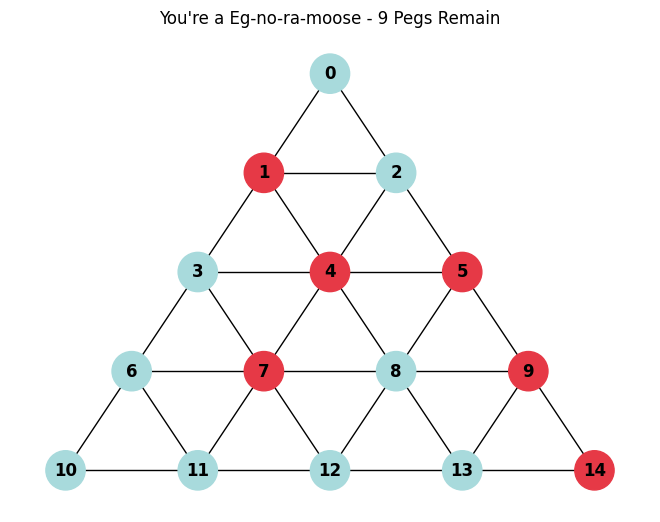

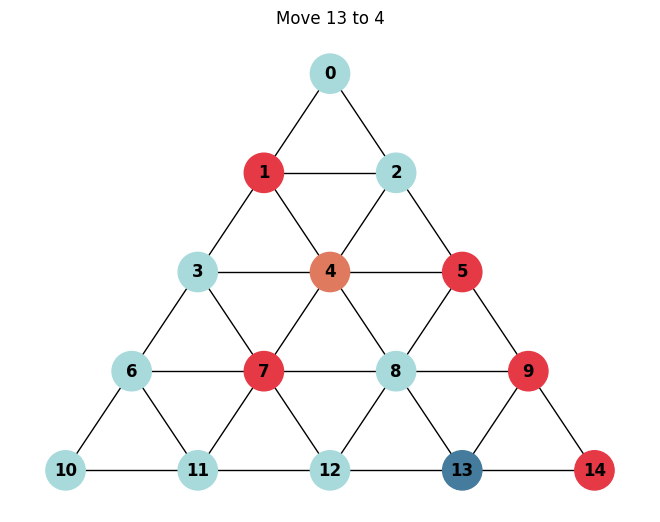

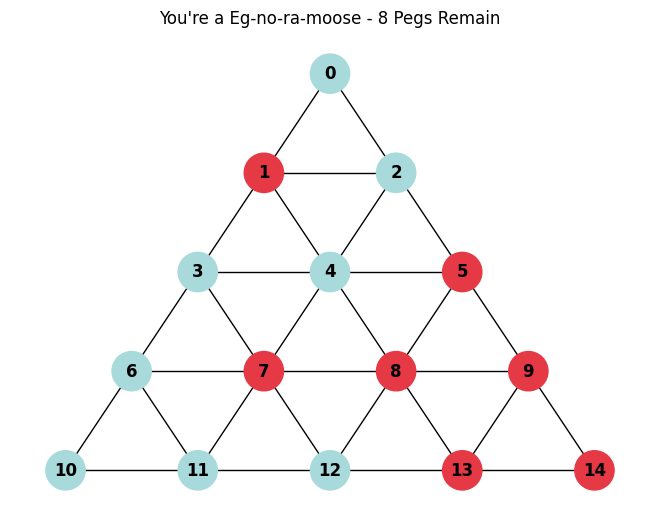

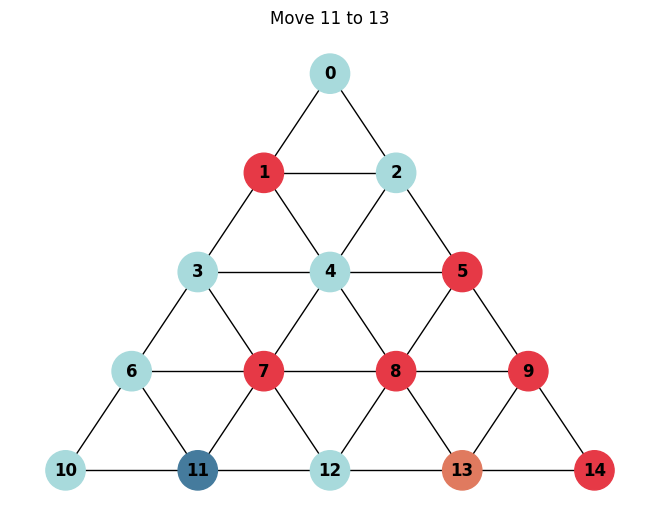

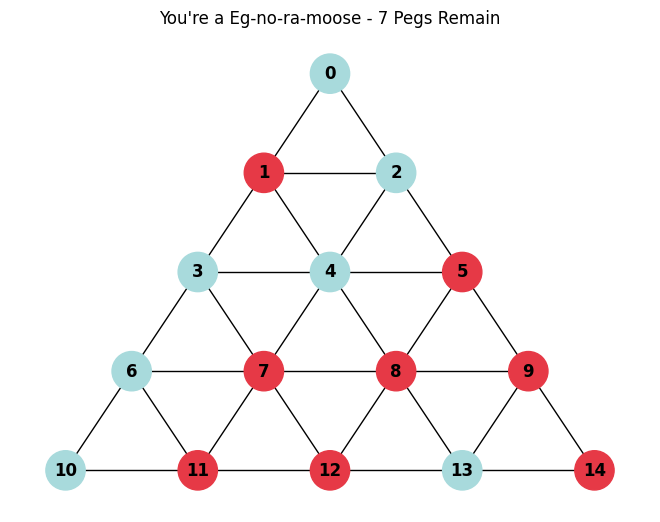

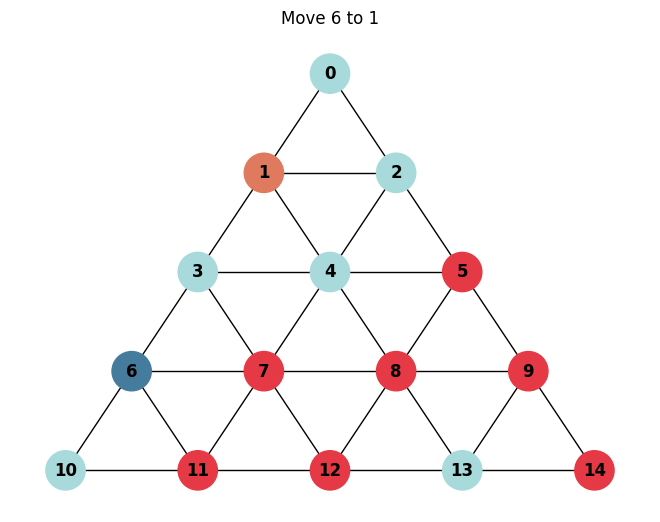

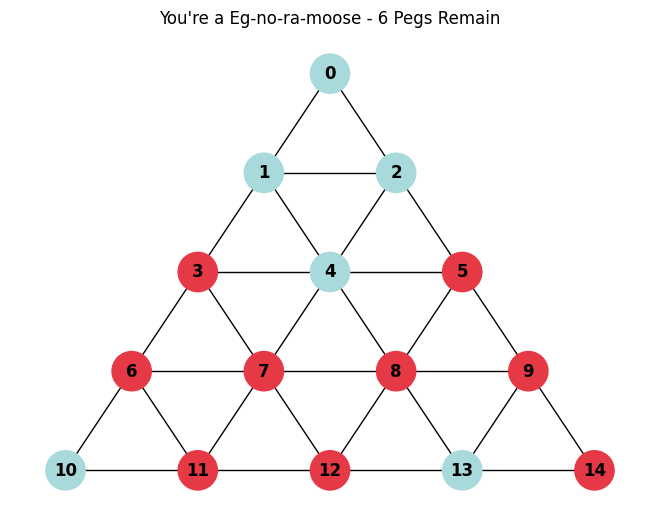

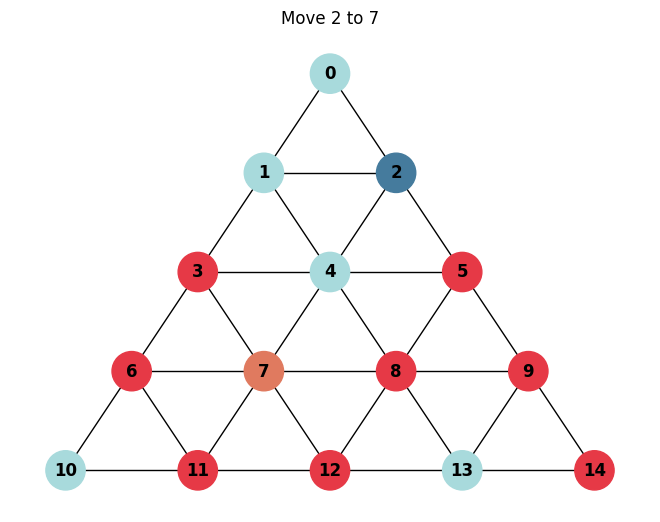

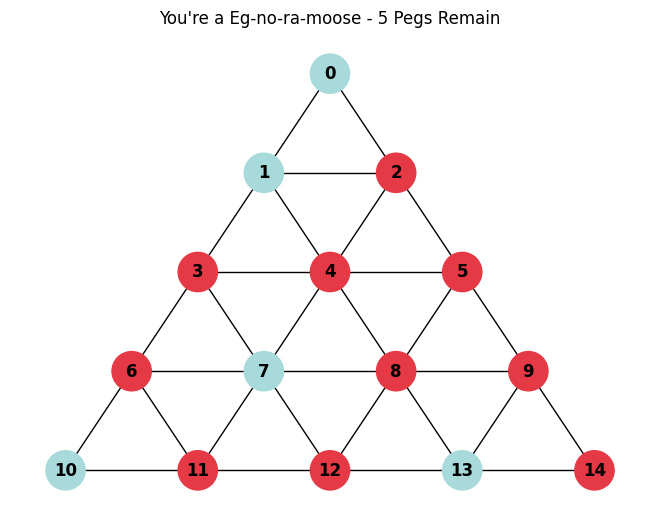

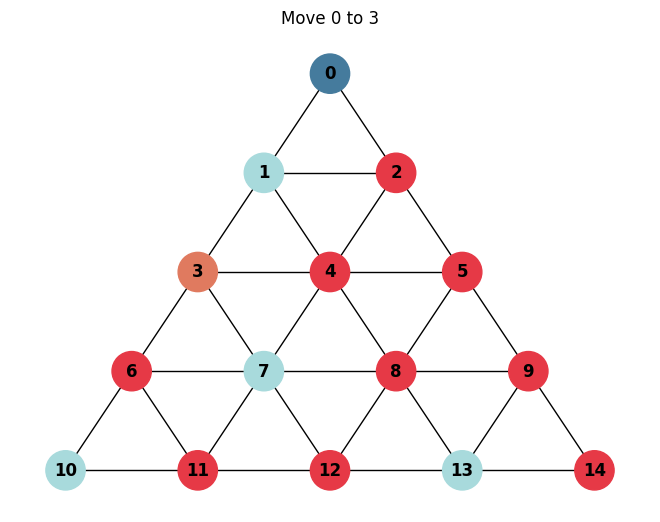

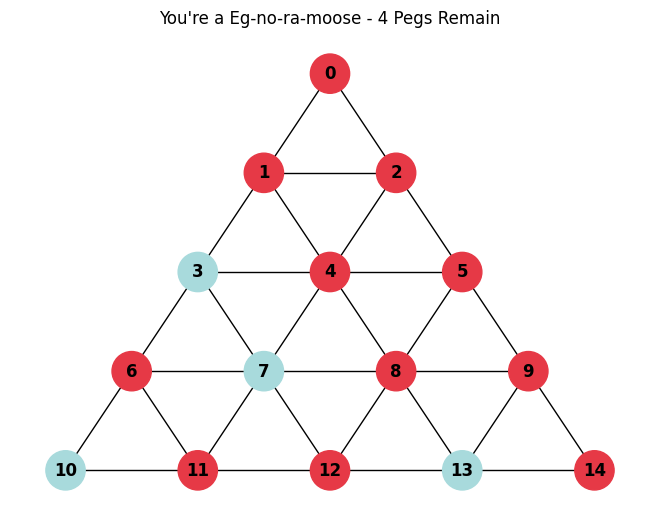

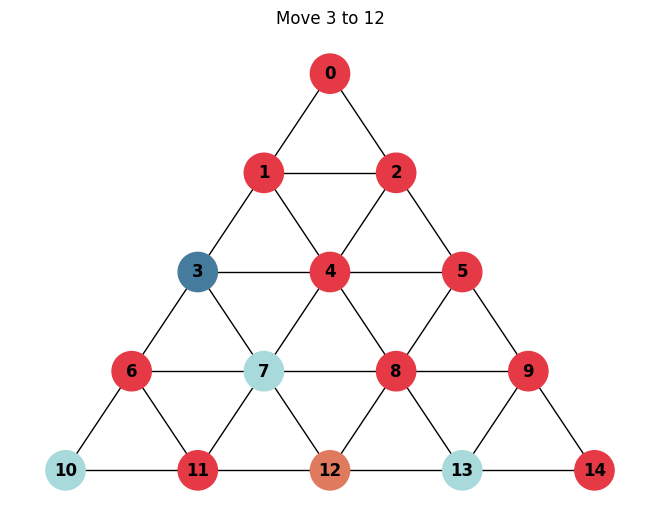

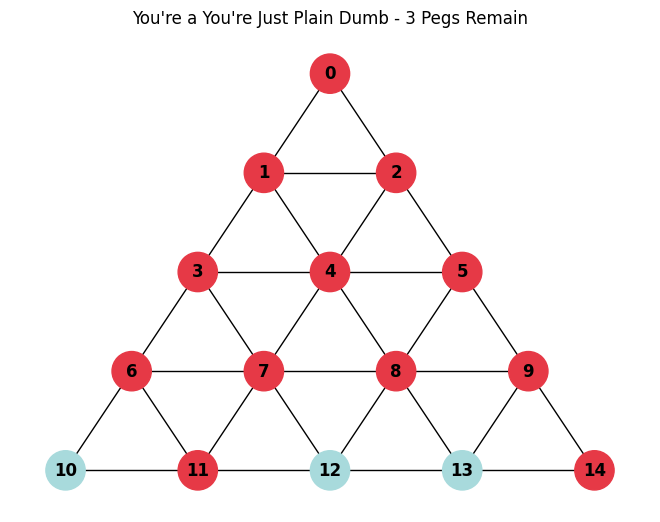

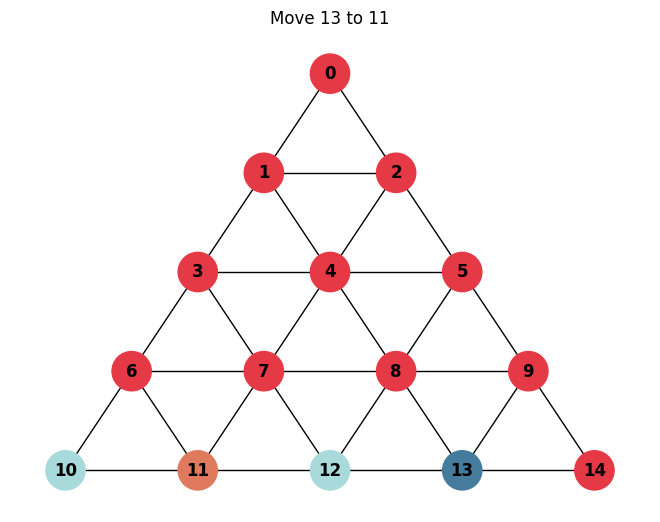

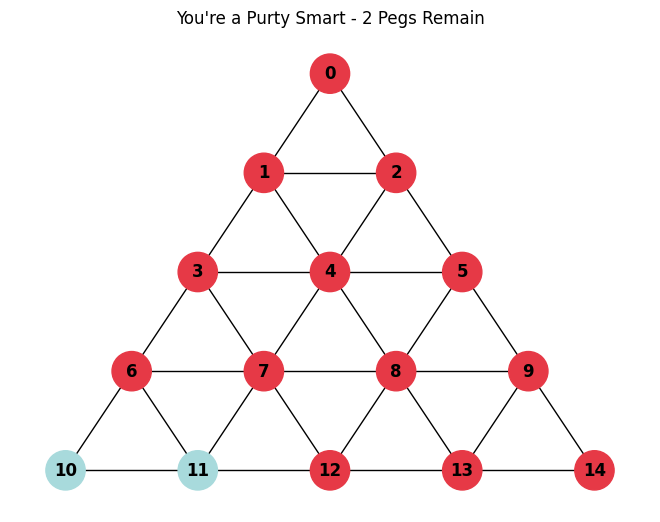

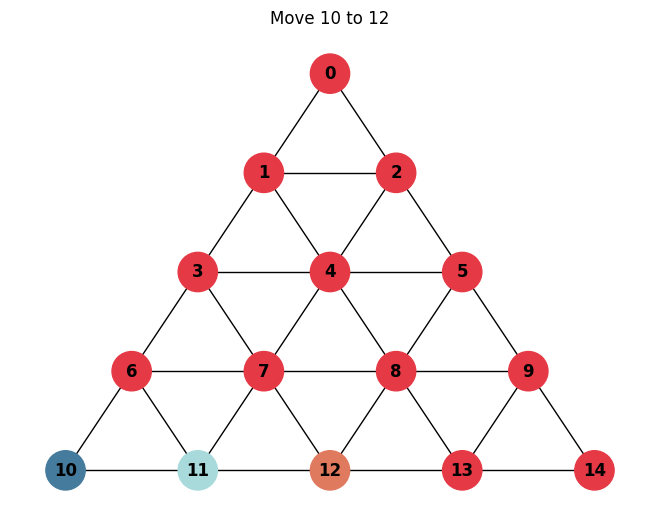

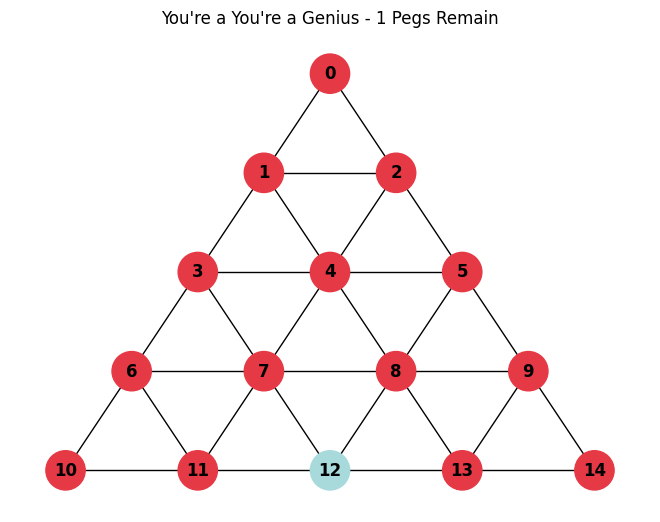

In [167]:
state = starting_board
for move in solution:
    draw_board(state)
    draw_move(state,move)
    state = process_move(state,move)
draw_board(state)